1. Setup and load data
  
  1.1 install dependencies and setup

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten,Input
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from keras.callbacks import ModelCheckpoint
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.metrics import confusion_matrix, classification_report
from IPython.display import display, HTML
import cv2
import imghdr

In [ ]:
os.path.join('data','happy')

'data/happy'

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')

In [ ]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
# menghindari OOM errors dengan mensetting GPU memory consumption growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

1.2 Remove dodgy images

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/tugas_akhir

/content/drive/MyDrive/tugas_akhir


In [ ]:
data_dir = '/content/drive/MyDrive/tugas_akhir/data_original'

In [ ]:
os.listdir(os.path.join(data_dir))

['level_0', 'level_1', 'level_2', 'level_3']

In [ ]:
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [ ]:
image_exts[1]

'jpg'

In [ ]:
filepaths=[]
labels=[]
classlist=os.listdir(data_dir)
for klass in classlist:
    classpath=os.path.join(data_dir,klass)
    if os.path.isdir(classpath):
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)
Fseries= pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries, Lseries], axis=1)
print (df.head())
print (df['labels'].value_counts())

                                           filepaths   labels
0  /content/drive/MyDrive/tugas_akhir/data_origin...  level_0
1  /content/drive/MyDrive/tugas_akhir/data_origin...  level_0
2  /content/drive/MyDrive/tugas_akhir/data_origin...  level_0
3  /content/drive/MyDrive/tugas_akhir/data_origin...  level_0
4  /content/drive/MyDrive/tugas_akhir/data_origin...  level_0
level_0    160
level_1    150
level_2    150
level_3    150
Name: labels, dtype: int64


In [ ]:
train_split=.8
test_split=.1
dummy_split=test_split/(1-train_split)
train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_df, valid_df=train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print ('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df length:  488   test_df length:  61   valid_df length:  61


In [ ]:
for image_class in os.listdir(data_dir):
  for image in os.listdir(os.path.join(data_dir, image_class)):
    print(image)

czv-panto-1a.jpg
153328646o.jpg
1 (10)q.jpg
kl65.jpg
po76.jpg
Asian1.jpg
59948a2722000009371a64e3p.jpg
sa5.jpg
153328646a.jpg
2015 r.jpg
4245q.jpg
download7.jpg
kl6.jpg
yt5.jpg
asdf5.jpg
1234567a.jpg
123456p.jpg
2015 5.jpg
po765.jpg
download8.jpg
4245ae.jpg
qwwe1.jpg
Asian4.jpg
yui1.jpg
assdf5.jpg
download0.jpg
123456a.jpg
1 (10)s.jpg
1 (1003)a.jpg
we4.jpg
po9.jpg
we`1.jpg
po45.jpg
ttt2.jpg
asdf1.jpg
ch7.jpg
asd3.jpg
1 (1004)a.jpg
1 (1045)a.jpg
4245p.jpg
zx1.jpg
1234567g.jpg
59948a2722000009371a64e3q.jpg
download4.jpg
20151.jpg
yyy1.jpg
asfd1.jpg
1 (1095).jpg
kl5.jpg
po564.jpg
1533286460.jpg
er1.jpg
Asiany.jpg
1 (1005)a.jpg
tr5.jpg
qwer4.jpg
qwe3.jpg
images (3).jpg
asyu1.jpg
2015 4.jpg
ttt1.jpg
download2.jpg
images (9).jpg
czv-panto-1d.jpg
6862014431.jpg
yt1.jpg
4245s.jpg
ch1.jpg
ch79.jpg
1 (1095)g.jpg
er14.jpg
1 (1004)q.jpg
1 (1045)u.jpg
images (7).jpg
686201443a.jpg
1 (1044)a.jpg
1 (1093).jpg
tr1.jpg
1 (1044).jpg
iu4.jpg
123456y.jpg
relaxed3.jpg
download3.jpg
we23.jpg
4655q.jpg
1234.

In [ ]:
height=224
width=224
channels=3
batch_size=64

img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)



test batch size:  61   test steps:  1


In [ ]:
gen=ImageDataGenerator(
    rescale=1./255,
    )
train_gen=gen.flow_from_dataframe( train_df,
                                  x_col='filepaths',
                                   y_col='labels',
                                   target_size=img_size,
                                   class_mode='categorical',
                                   color_mode='rgb',
                                   shuffle=True, batch_size=batch_size,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

validgen=ImageDataGenerator(rescale=1./255)
valid_gen=validgen.flow_from_dataframe( valid_df,
                                       x_col='filepaths',
                                       y_col='labels',
                                       target_size=img_size,
                                       class_mode='categorical',
                                       color_mode='rgb',
                                        shuffle=True,
                                        batch_size=batch_size,
                                        rotation_range=40,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        shear_range=0.2,
                                        zoom_range=0.2,
                                        horizontal_flip=True,
                                        fill_mode='nearest')

testgen=ImageDataGenerator(rescale=1./255)
test_gen=testgen.flow_from_dataframe( test_df,
                                     x_col='filepaths',
                                      y_col='labels',
                                      target_size=img_size,
                                      class_mode='categorical',
                                      color_mode='rgb',
                                      shuffle=False,
                                      batch_size=test_batch_size,
                                      rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      fill_mode='nearest')

classes=list(train_gen.class_indices.keys())
print (classes)
class_count=len(classes)


Found 488 validated image filenames belonging to 4 classes.
Found 61 validated image filenames belonging to 4 classes.
Found 61 validated image filenames belonging to 4 classes.
['level_0', 'level_1', 'level_2', 'level_3']


In [ ]:
def show_image_samples(gen):
    test_dict=test_gen.class_indices
    classes=list(test_dict.keys())
    images,labels=next(gen) # get a sample batch from the generator
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

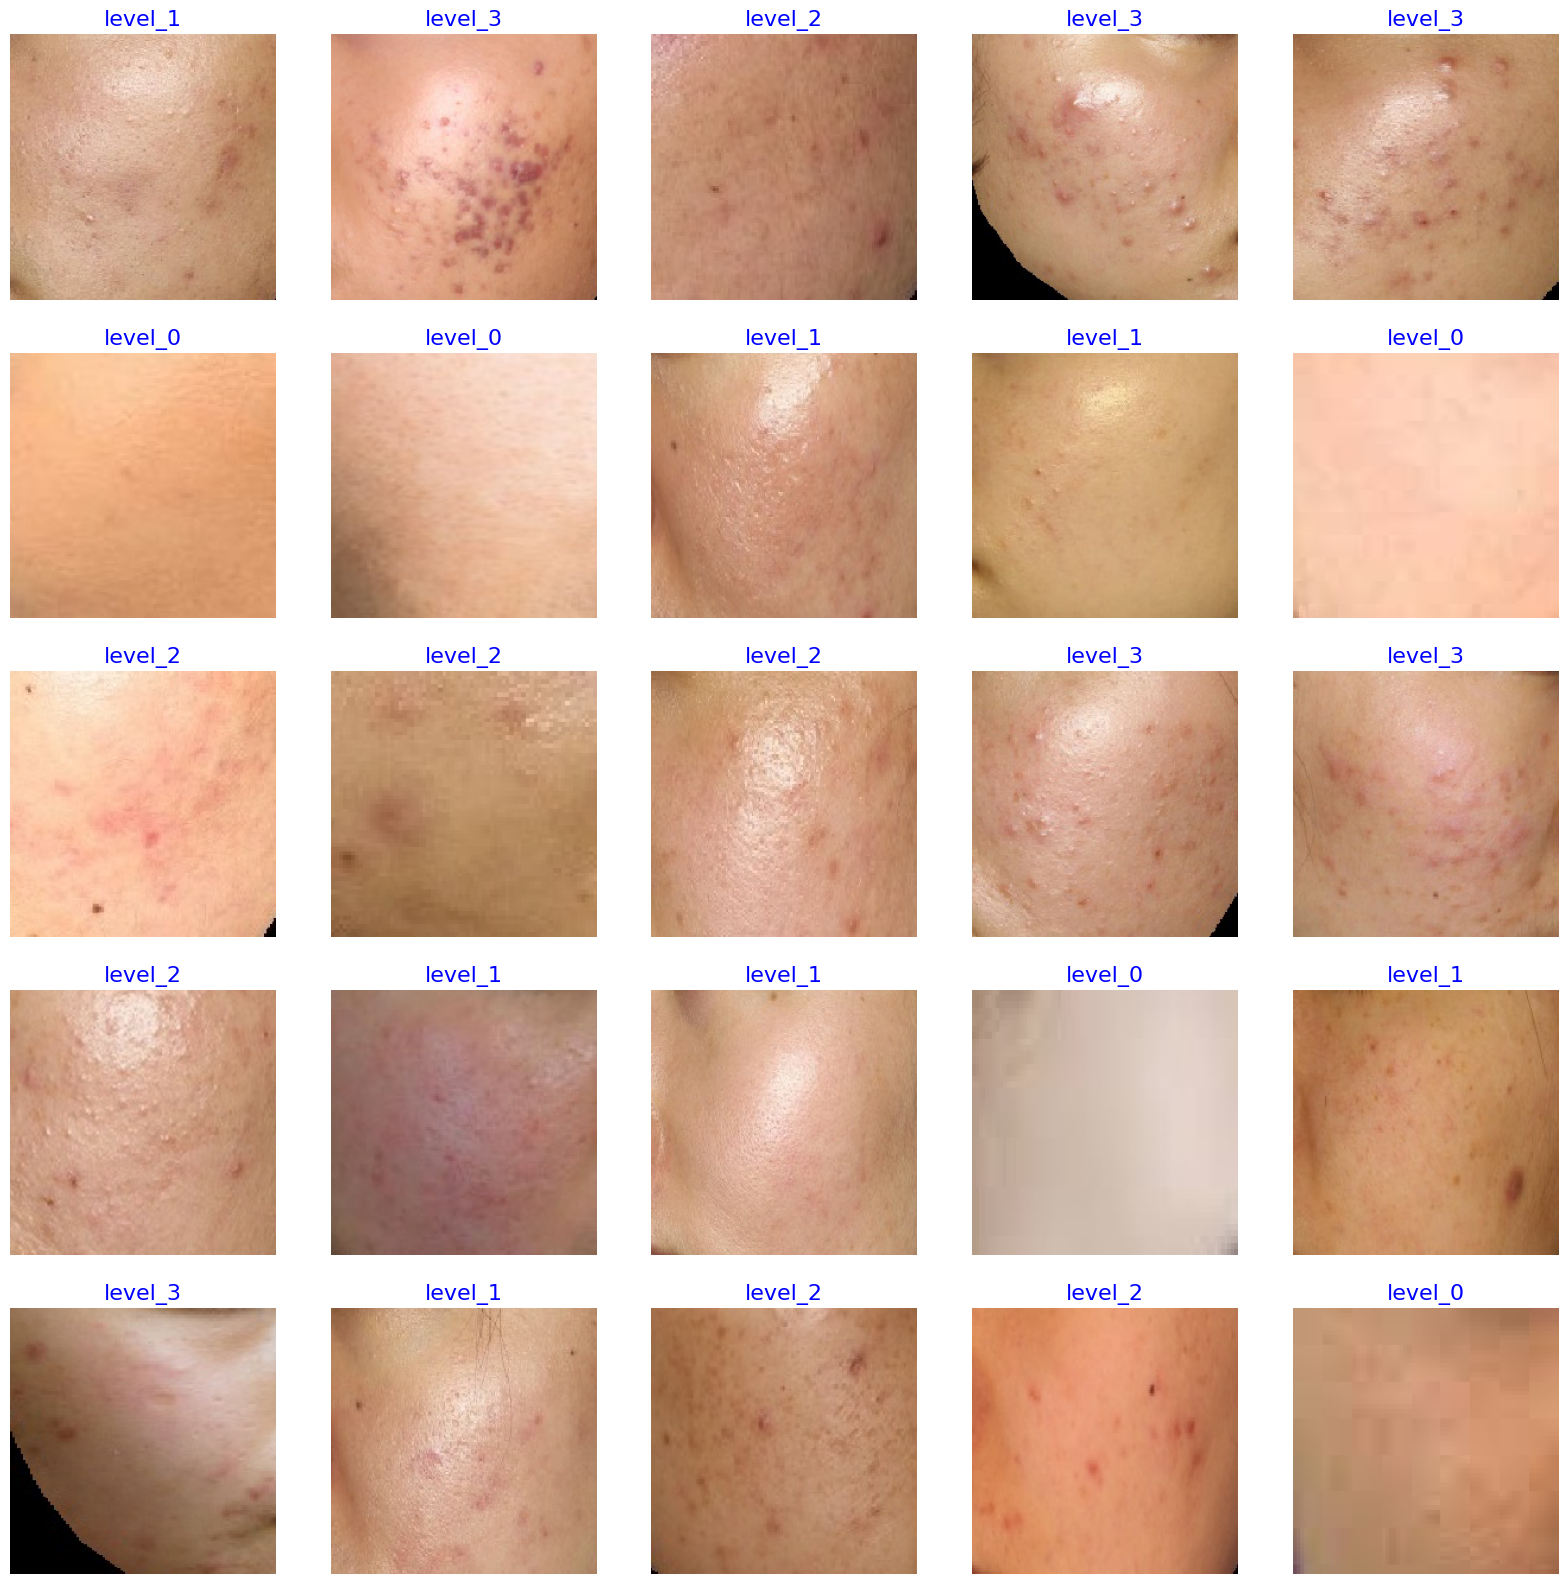

In [ ]:
show_image_samples(train_gen)

**3. Deep Model**

3.1 Build Deep Learning model

In [ ]:
# JANGAN DI RUN DULU base model lama
base_model=tf.keras.applications.Xception(include_top=False, weights="imagenet",input_tensor=Input(shape=(224,224,3)))

83683744/83683744 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 111, 111, 32)         0         ['block1_conv1_bn[0][0]

In [ ]:
last_layer = base_model.get_layer('block13_sepconv2')

last_output = last_layer.output

In [ ]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model
from tensorflow.keras import layers


x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(1, activation='softmax')(x)

model = Model( base_model.input, x)
model.compile(optimizer = RMSprop(learning_rate=0.0001),
              loss = 'categorical_crossentropy',
              metrics = ['acc'])

In [ ]:
model.trainable = False

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [ ]:
# Model Baru
model_name='AcneLevel'
print("Building model with", base_model)
model = tf.keras.Sequential([
            # Note the input shape is the desired size of the image 128x128 with 3 bytes color
            # This is the first convolution
            base_model,
            tf.keras.layers.Conv2D(filters=32, padding='same', kernel_size=3, activation='relu', strides=1),
            tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
            tf.keras.layers.Dropout(rate=0.5),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(4, activation='softmax')
])


Building model with <keras.src.engine.functional.Functional object at 0x7cb42b54db10>


In [ ]:
# model.compile BARU
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.0001), loss='categorical_crossentropy', metrics='accuracy')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 32)          589856    
                                                                 
 max_pooling2d (MaxPooling2  (None, 3, 3, 32)          0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 3, 3, 32)          0         
                                                                 
 flatten_1 (Flatten)         (None, 288)               0         
                                                                 
 dense_2 (Dense)             (None, 4)                 1156      
                                                        

3.2 Train

In [ ]:
epochs =100

history=model.fit(x=train_gen, epochs=epochs, validation_data=valid_gen)

Epoch 1/100
8/8 [==============================] - 126s 15s/step - loss: 1.2982 - accuracy: 0.3770 - val_loss: 1.1125 - val_accuracy: 0.5738
Epoch 2/100
8/8 [==============================] - 3s 349ms/step - loss: 0.8019 - accuracy: 0.7643 - val_loss: 0.8513 - val_accuracy: 0.7049
Epoch 3/100
8/8 [==============================] - 3s 352ms/step - loss: 0.4525 - accuracy: 0.8586 - val_loss: 0.7303 - val_accuracy: 0.7541
Epoch 4/100
8/8 [==============================] - 3s 374ms/step - loss: 0.3269 - accuracy: 0.8852 - val_loss: 0.6578 - val_accuracy: 0.7541
Epoch 5/100
8/8 [==============================] - 3s 362ms/step - loss: 0.2100 - accuracy: 0.9406 - val_loss: 0.6162 - val_accuracy: 0.7869
Epoch 6/100
8/8 [==============================] - 3s 362ms/step - loss: 0.1447 - accuracy: 0.9611 - val_loss: 0.5479 - val_accuracy: 0.8197
Epoch 7/100
8/8 [==============================] - 3s 370ms/step - loss: 0.0914 - accuracy: 0.9918 - val_loss: 0.5747 - val_accuracy: 0.8033
Epoch 8/100
8

In [ ]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m'
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

In [ ]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()

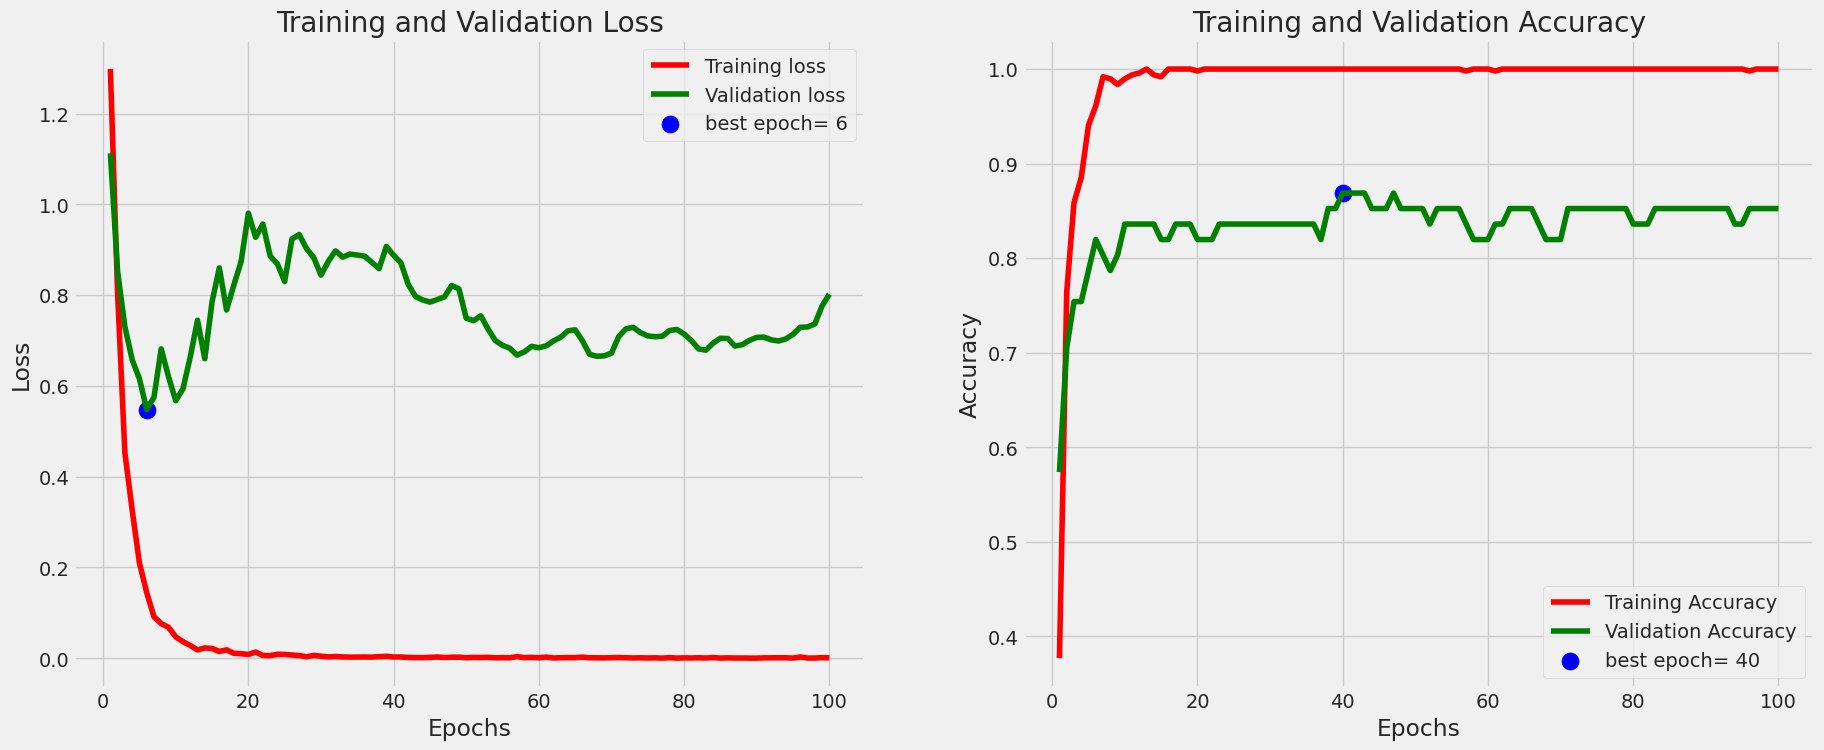

1/1 [==============================] - 1s 528ms/step - loss: 0.1688 - accuracy: 0.9344
accuracy on the test set is 93.44 %



/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
tr_plot(history,0)
save_dir=r'./'
subject='Acne Level'
acc=model.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
save_id=str (model_name +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
save_loc=os.path.join(save_dir, save_id)
model.save(save_loc)

In [ ]:
from tensorflow.keras.models import load_model

model.save(os.path.join('models','acnelevel-v4.2.h5'))

new_model = load_model(os.path.join('models', 'acnelevel-v4.2.h5'))
"""
note
(transfer learning Xception)
acnelevel-v1   = trial pertama
acnelevel-v1.2 = trial pertama lagi tapi dengan data yang telah pakai train image generator
acnelevel-v2   = data dengan tambahan data dari kaggle
acnelevel-v3   = data dengan tambahan data dari kaggle + train image generator
(transfer learning resnet-18)
acnelevel-v4   = data pertama dengan transfer learning resnet-v18 (epochs=10)
acnelevel-v4.2   = data pertama dengan transfer learning resnet-v18 (epochs=100)
"""

'\nnote\n(transfer learning Xception)\nacnelevel-v1   = trial pertama\nacnelevel-v1.2 = trial pertama lagi tapi dengan data yang telah pakai train image generator\nacnelevel-v2   = data dengan tambahan data dari kaggle\nacnelevel-v3   = data dengan tambahan data dari kaggle + train image generator\n(transfer learning resnet-18)\nacnelevel-v4   = data pertama dengan transfer learning resnet-v18 (epochs=10)\nacnelevel-v4.2   = data pertama dengan transfer learning resnet-v18 (epochs=100)\n'

In [ ]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'
    dict_path=os.path.join(save_dir,dict_name)
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)
    errors=0
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)
            errors=errors + 1
        y_pred.append(pred_index)
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):
                split1=os.path.split(error_list[i])
                split2=os.path.split(split1[0])
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():
            count=error_indices.count(key)
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        # create a confusion matrix
        cm = confusion_matrix(y_true, y_pred )
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

1/1 [==============================] - 1s 1s/step


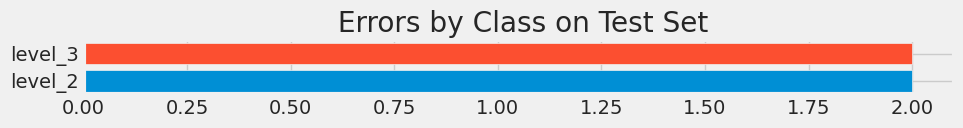

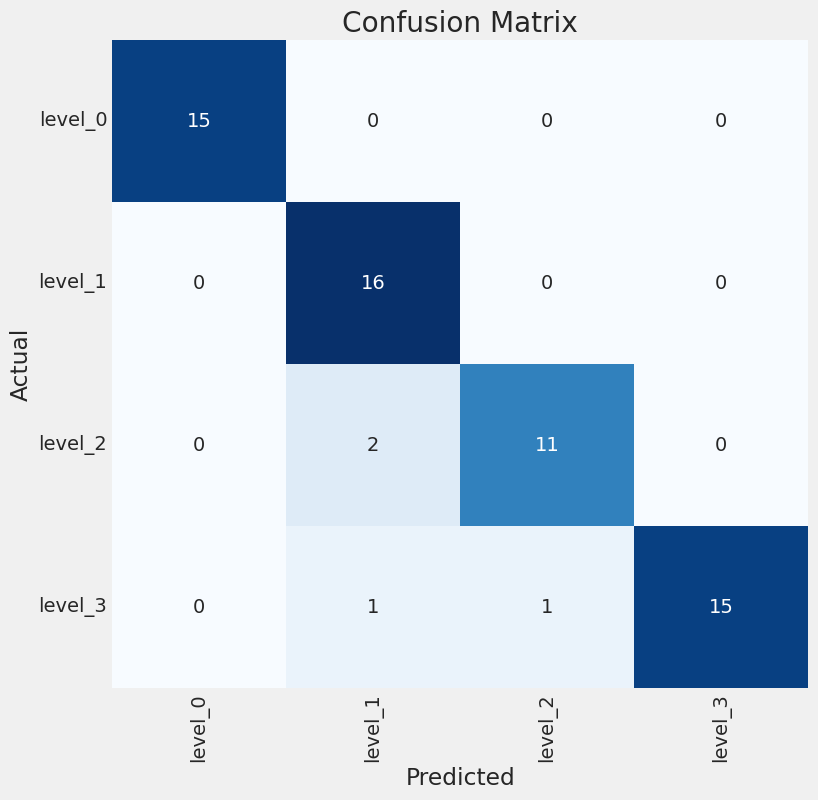

Classification Report:
----------------------
               precision    recall  f1-score   support

     level_0       1.00      1.00      1.00        15
     level_1       0.84      1.00      0.91        16
     level_2       0.92      0.85      0.88        13
     level_3       1.00      0.88      0.94        17

    accuracy                           0.93        61
   macro avg       0.94      0.93      0.93        61
weighted avg       0.94      0.93      0.93        61



In [ ]:
print_code=0
preds=model.predict(test_gen)
print_info( test_gen, preds, print_code, save_dir, subject )